### Building bayesian latent class analysis models

### Goal
The goal of this notebook is to show how a bayesian latent class analysis can be carried out using pymc and MCMC. 

### Data
There are two datasets to explore (generated in the generate_data.ipynb notebook). The first dataset is a univariate dataset with 1000 samples from two data generating processes (500 samples from each process). Both of these generate normally distributed values with very little overlap between the two groups. The second dataset is a bit more complex. Three underlying groups generate a multivariate dataset (500 samples from each group). Each sample has the following structure: x1 and x2 are normally distributed and x3 is Poisson distributed. There is significant overlap between groups when looking at one or two variables at a time, looking at all three, it should be possible to group the data properly. See the other notebook for visualizations of the datasets. Here, the first dataset will be used.

### Model structure
Assumptions about the number of groups and distributions of emission variables will be made. The latter with weak priors. Model comparison will be carried out using PSIS-LOO or WAIC.

In [12]:
#Import libraries
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az

### Model 1
This model is for dataset_1 (univariate normal). For technical reasons (eg. limited programing skills), two models are defined. One for k = 1 classes, and one for k > 1 classes. 

In [13]:
#Load data
dataset_1 = pd.read_csv("dataset_1.csv", index_col=0)

In [14]:
#One class model
with pm.Model() as model_1:
    data = dataset_1.x1

    #Priors
    mu = pm.Normal("mu", 0, 5)
    sigma = pm.HalfNormal("sigma", 5)

    #Likelihood
    likelihood = pm.Normal("likelihood", mu, sigma, observed=data)

    trace_1 = pm.sample(draws=1000, chains=2, return_inferencedata=True, idata_kwargs = {'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.


In [15]:
#now, let's run more models with k>1 classes and store them
#k class models
k_values = [2, 3, 4, 5]

traces = {}

In [23]:
#store the model we just ran
traces["1_class_model"] = trace_1

In [17]:
#k class models
k_values = [2, 3, 4, 5]

traces = {}

for k in k_values:
    with pm.Model() as model_3:
        data = dataset_1.x1
        
        #Latent class probability
        p = pm.Dirichlet("p", np.ones(k))

        #Latent class assignment
        z = pm.Categorical("z", p, shape=len(data))

        #Priors
        mu = pm.Normal("mu", 0, 5, size=k)
        sigma = pm.HalfNormal("sigma", 5, size=k)

        #Likelihood
        likelihood = pm.Normal("likelihood", mu[z], sigma[z], observed=data)

        traces[f"{k}_class_model"] = pm.sample(draws=1000, chains=2, return_inferencedata=True, idata_kwargs = {'log_likelihood': True})

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu, sigma]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 86 seconds.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu, sigma]
>CategoricalGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 128 seconds.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu, sigma]
>CategoricalGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 127 seconds.
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [p, mu, sigma]
>CategoricalGibbsMetropolis: [z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 130 seconds.


Let's compare the models. Warnings are suppressed (arviz throws several warnings which are relevant, but ignored for now).

In [18]:
import warnings
warnings.filterwarnings('ignore')

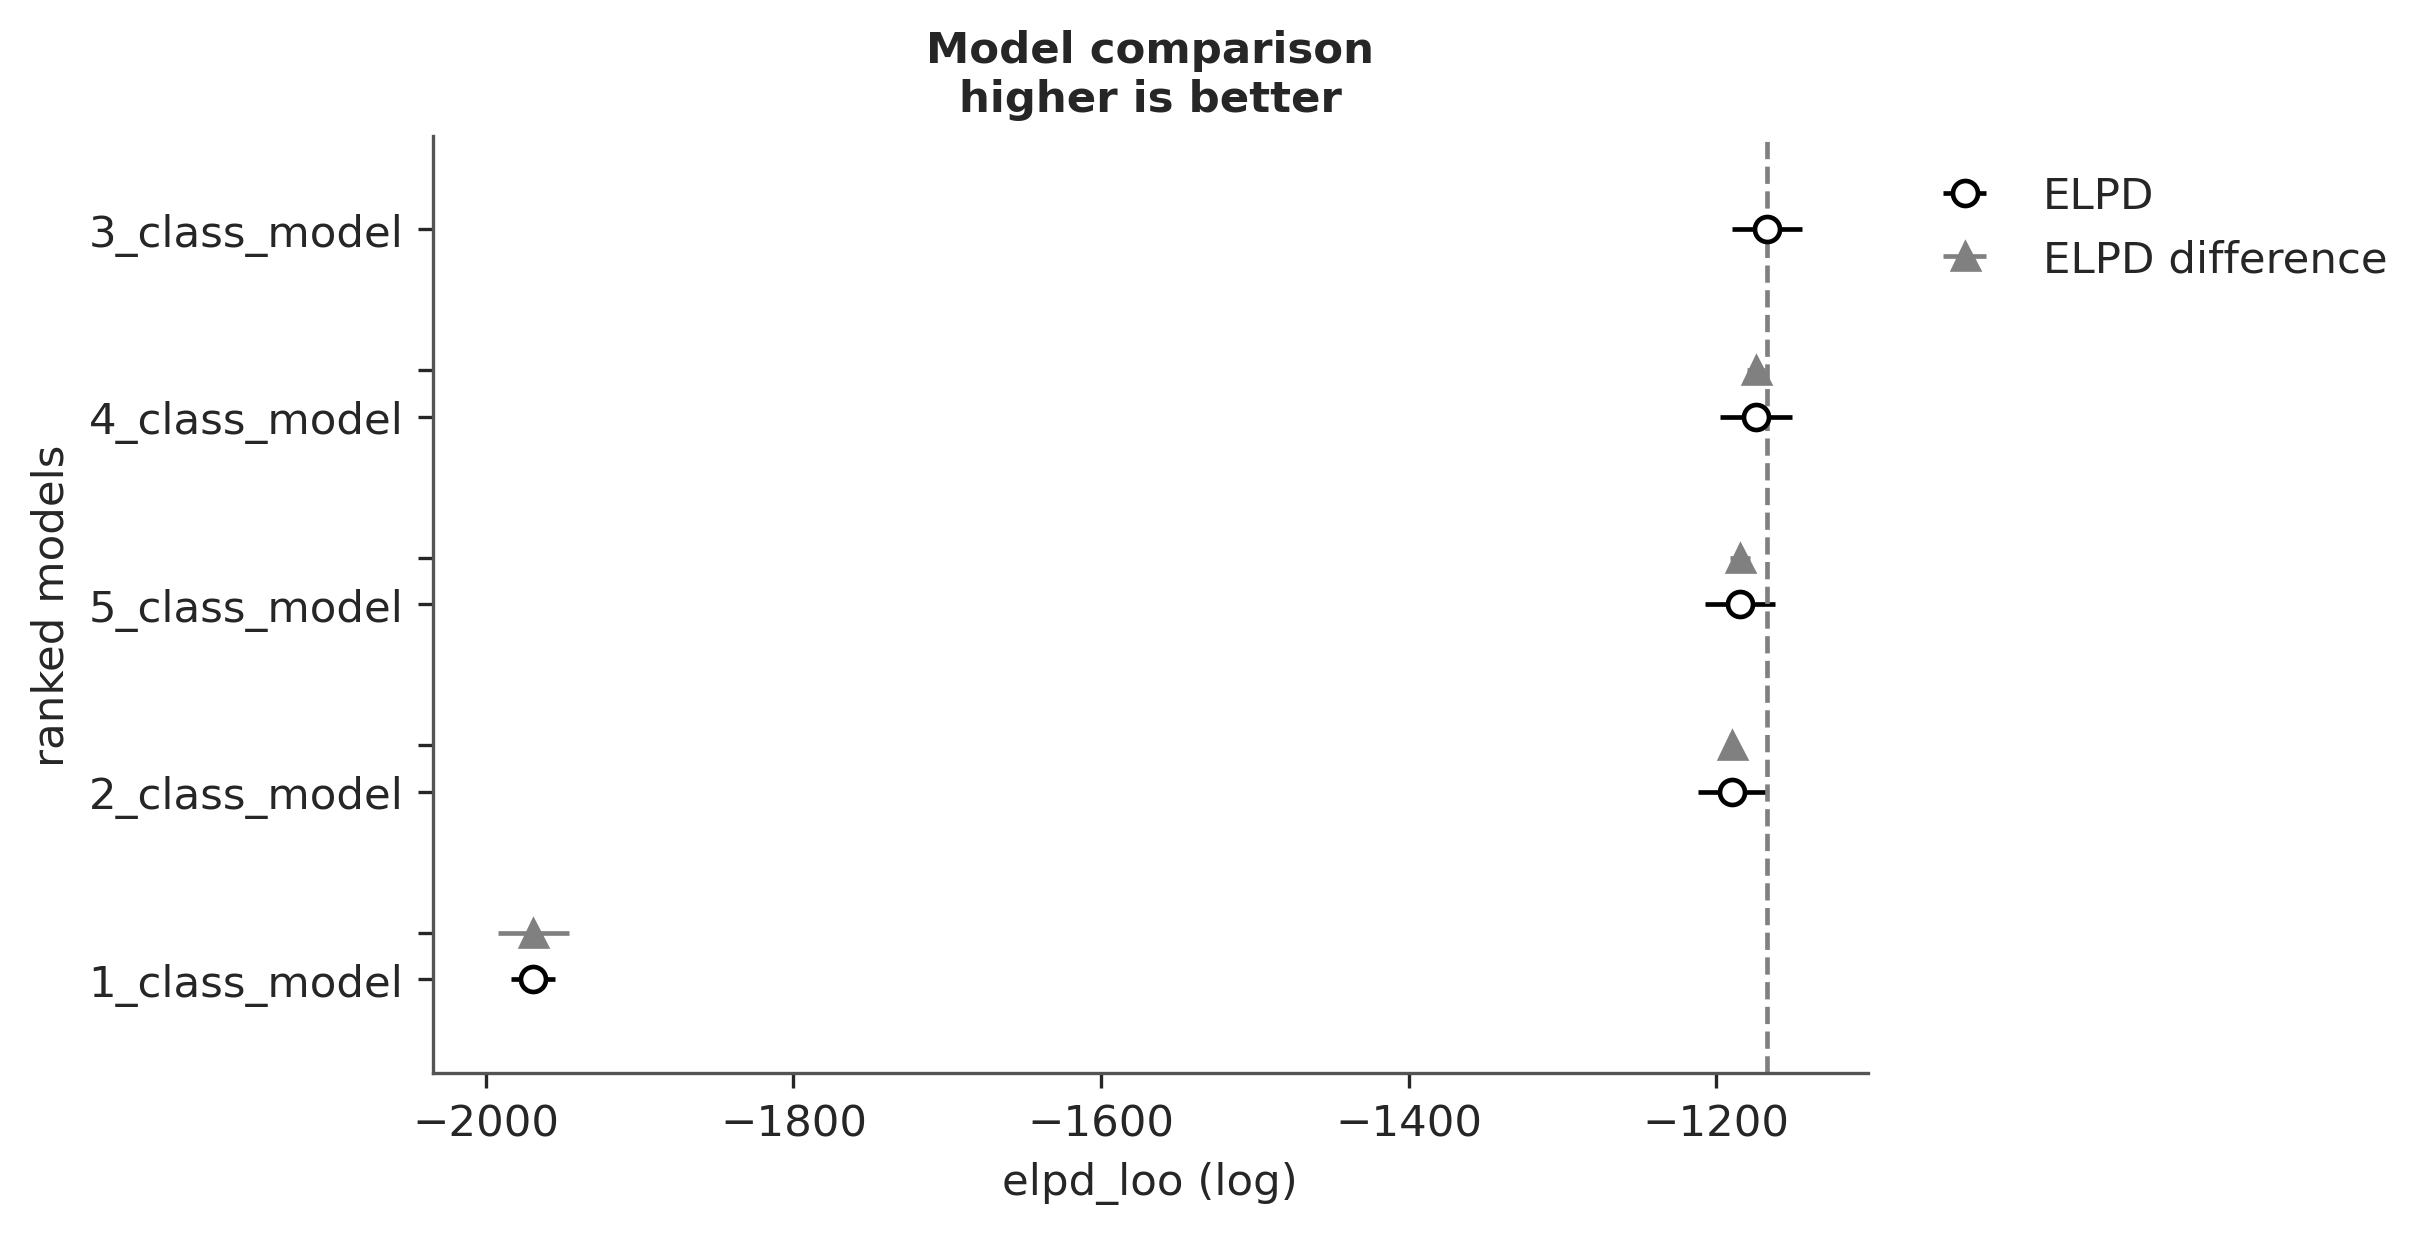

In [25]:
comparison = az.compare(traces, ic="loo")
az.style.use("arviz-doc")
az.plot_compare(comparison, figsize=(8,4));

Using PSIS-LOO as the comparison method, it would be reasonable to choose the 2 class model given it's performance and because it is more parsimonious. Also, if you take a close look at the sampling of the 3 class model, you will see that it's not doing great. Looking at the trace plot, the chain for both the mu and sigma parameter for one of the classes is doing wonky stuff. My uninformed idea about why: the other two classes fully explain the data, thus this third class is left trying to explain the unlikely outliers from the two data generating processes.

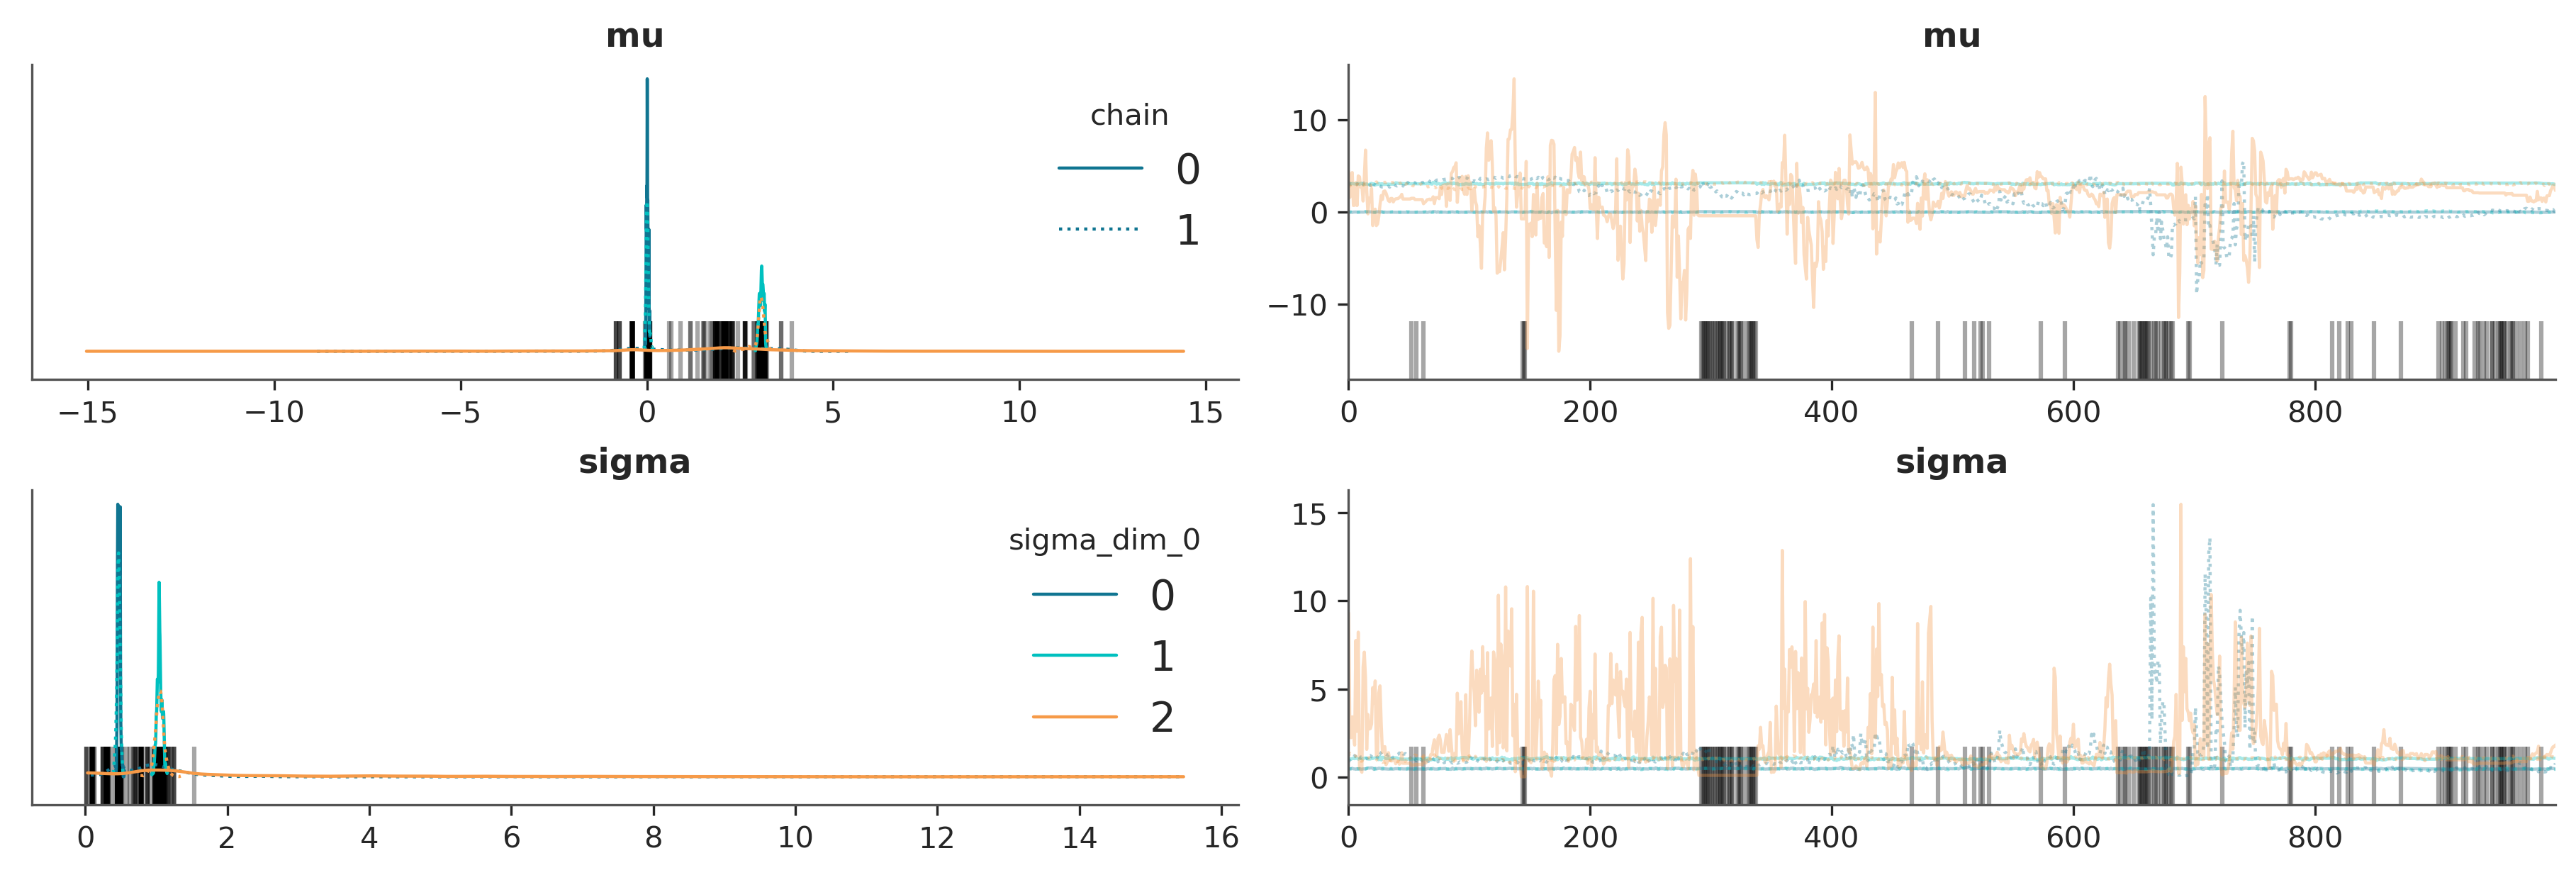

In [29]:
az.plot_trace(traces["3_class_model"], var_names=["mu", "sigma"], legend=True);